##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 简单的音频识别：识别关键词

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/audio/simple_audio"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a> </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/audio/simple_audio.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/audio/simple_audio.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/audio/simple_audio.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a> </td>
</table>

本教程演示了如何预处理 WAV 格式的音频文件，并构建和训练一个基本的<a href="https://en.wikipedia.org/wiki/Speech_recognition" class="external">自动语音识别</a> (ASR) 模型来识别十个不同的单词。您将使用 [Speech Commands 数据集](https://tensorflow.google.cn/datasets/catalog/speech_commands)（<a href="https://arxiv.org/abs/1804.03209" class="external">Warden，2018 年</a>）的一部分，其中包含命令的短（一秒或更短）音频片段，例如“down”、“go”、“left”、“no”、“right”、“stop”、“up”和“yes”。

现实世界的语音和音频识别<a href="https://ai.googleblog.com/search/label/Speech%20Recognition" class="external">系统</a>很复杂。但是，就像[使用 MNIST 数据集进行图像分类](../quickstart/beginner.ipynb)一样，本教程应该能够使您对所涉及的技术有一个基本的了解。

## 设置

导入必要的模块和依赖项。您将使用 `tf.keras.utils.audio_dataset_from_directory`（在 TensorFlow 2.10 中引入），它有助于从 `.wav` 文件的目录生成音频分类数据集。在本教程中，您还需要 [seaborn](https://seaborn.pydata.org) 进行呈现。

In [ ]:
!pip install -U -q tensorflow tensorflow_datasets
!pip install librosa soundfile
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## 导入迷你 Speech Commands 数据集

为了节省数据加载时间，您将使用较小版本的 Speech Commands 数据集。[原始数据集](https://tensorflow.google.cn/datasets/catalog/speech_commands)包含超过 105,000 个音频文件，采用 <a href="https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf" class="external">WAV（波形）音频文件格式</a>，内容是不同的人们说出 35 个不同的单词。此数据由 Google 收集并根据 CC BY 许可发布。

使用 `tf.keras.utils.get_file` 下载并提取包含较 Speech Commands 数据集的 `mini_speech_commands.zip`：

In [2]:
DATASET_PATH = 'mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

数据集的音频片段存储在与每个语音命令对应的八个文件夹中：`no`、`yes`、`down`、`go`、`left`、`up`、`right` 和 `stop`：

In [7]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['go' 'heymax' 'left' 'no' 'right' 'stop' 'up' 'yes']


查看样本采样率

In [6]:

import librosa

# 加载音频文件
audio_file = 'mini_speech_commands/heymax/heymax_l80_16k.wav'
audio_data, sample_rate = librosa.load(audio_file, sr=None)  # sr=None 保留原始采样率

# 输出采样率
print(f"Sample rate: {sample_rate} Hz")

Sample rate: 16000 Hz


In [8]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=32000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 7084 files belonging to 8 classes.
Using 5668 files for training.
Using 1416 files for validation.

label names: ['go' 'heymax' 'left' 'no' 'right' 'stop' 'up' 'yes']


数据集现在包含批量的音频剪辑和整数标签。音频剪辑的形状为 `(batch, samples, channels)`。 

In [9]:
train_ds.element_spec

(TensorSpec(shape=(None, 32000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

此数据集仅包含单声道音频，因此使用 `tf.squeeze` 函数删除额外的轴：

In [10]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

`utils.audio_dataset_from_directory` 函数最多只返回两个拆分。将测试集与验证集分开是一个好主意。理想情况下，您会将其保存在单独的目录中，但在这种情况下，您可以使用 `Dataset.shard` 将验证集拆分成两半。请注意，遍历**任何**分片将加载**所有**数据，并且只保留它的片段。 

In [11]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [12]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 32000)
(64,)


我们来绘制一些音频波形：

In [13]:
label_names[[1,1,3,0]]

array(['heymax', 'heymax', 'no', 'go'], dtype='<U6')

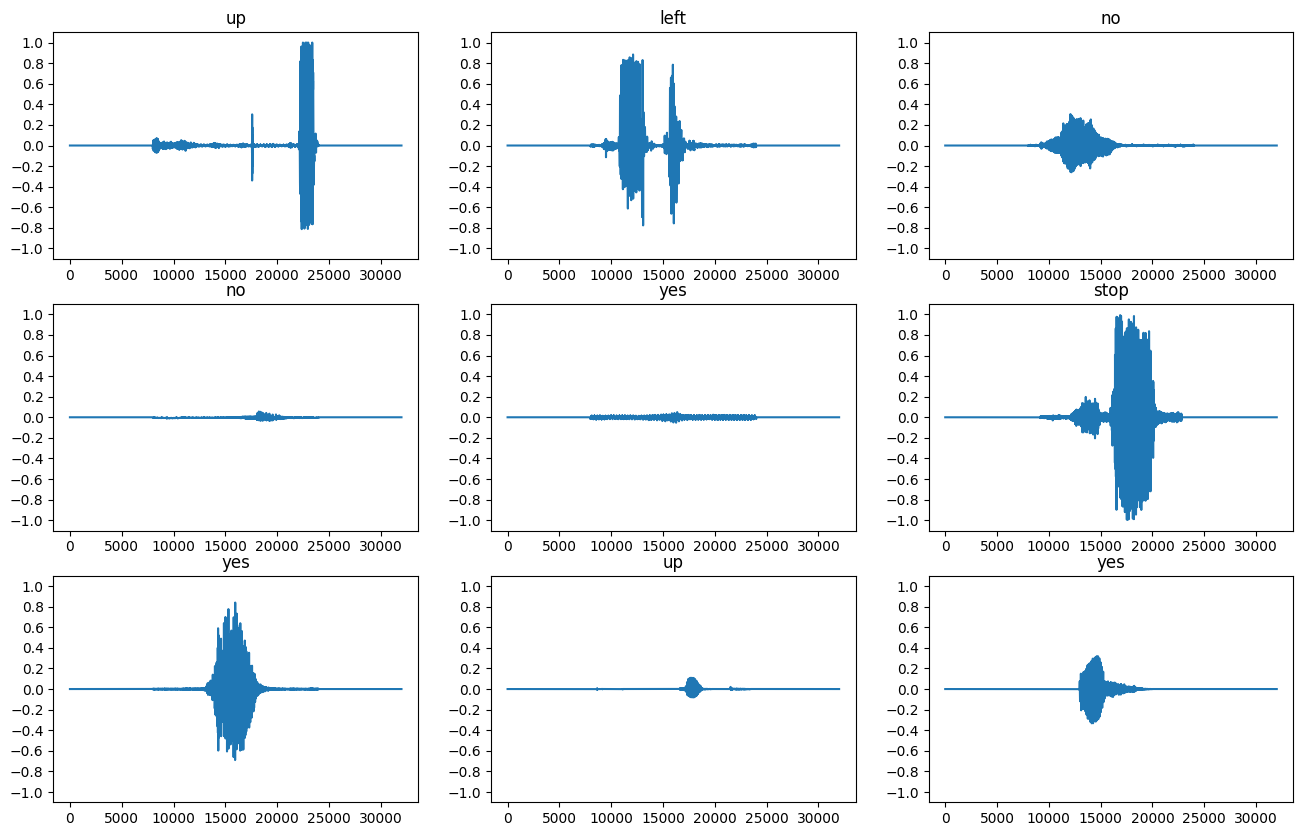

In [14]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## 将波形转换为频谱图

数据集中的波形在时域中表示。接下来，您将通过计算<a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">短时傅里叶变换 (STFT)</a> 将波形从时域信号转换为时频域信号，以将波形转换为<a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">频谱图</a>，显示频率随时间的变化，并且可以表示为二维图像。您将把频谱图图像输入您的神经网络以训练模型。

傅里叶变换 (`tf.signal.fft`) 会将信号转换为其分量频率，但会丢失所有时间信息。相比之下，STFT (`tf.signal.stft`) 会将信号拆分为时间窗口，并在每个窗口上运行傅里叶变换，保留一些时间信息，并返回可以运行标准卷积的二维张量。

创建用于将波形转换为频谱图的效用函数：

- 这些波形需要具有相同的长度，以便将它们转换为频谱图时，结果具有相似的维度。这可以通过简单地对短于一秒的音频片段进行零填充（使用 `tf.zeros`）来完成。
- 调用 `tf.signal.stft` 时，请选择 `frame_length` 和 `frame_step` 参数，使生成的频谱图“图像”几乎为方形。有关 STFT 参数选择的更多信息，请参阅有关音频信号处理和 STFT 的 <a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">Coursera 视频</a>。
- STFT 会产生表示幅度和相位的复数数组。但是，在本教程中，您将只使用幅度，您可以通过在 tf.signal.stft 的输出上应用 `tf.abs` 来获得该 `tf.signal.stft`。

In [15]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

接下来，开始探索数据。打印一个样本的张量波形形状和相应的频谱图，并播放原始音频：

In [16]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: up
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: left
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: no
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


现在，定义一个显示频谱图的函数：

In [17]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

绘制样本随时间变化的波形和相应的频谱图（随时间变化的频率）：

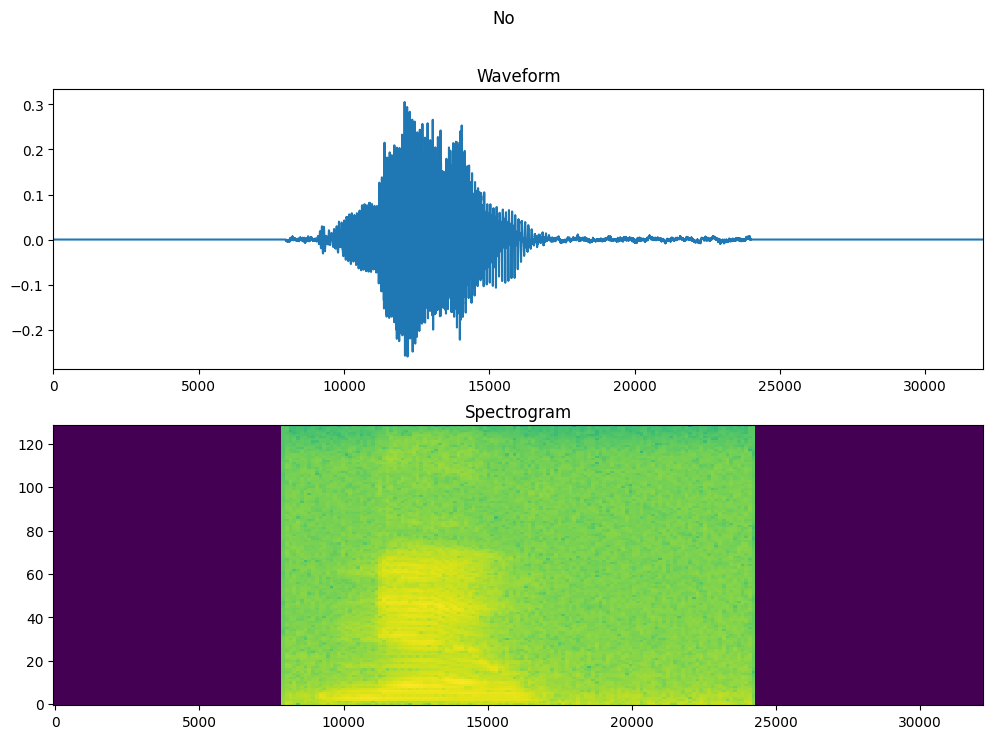

In [18]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 32000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

接下来，从音频数据集创建频谱图数据集：

In [19]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

检查数据集不同样本的频谱图：

In [21]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

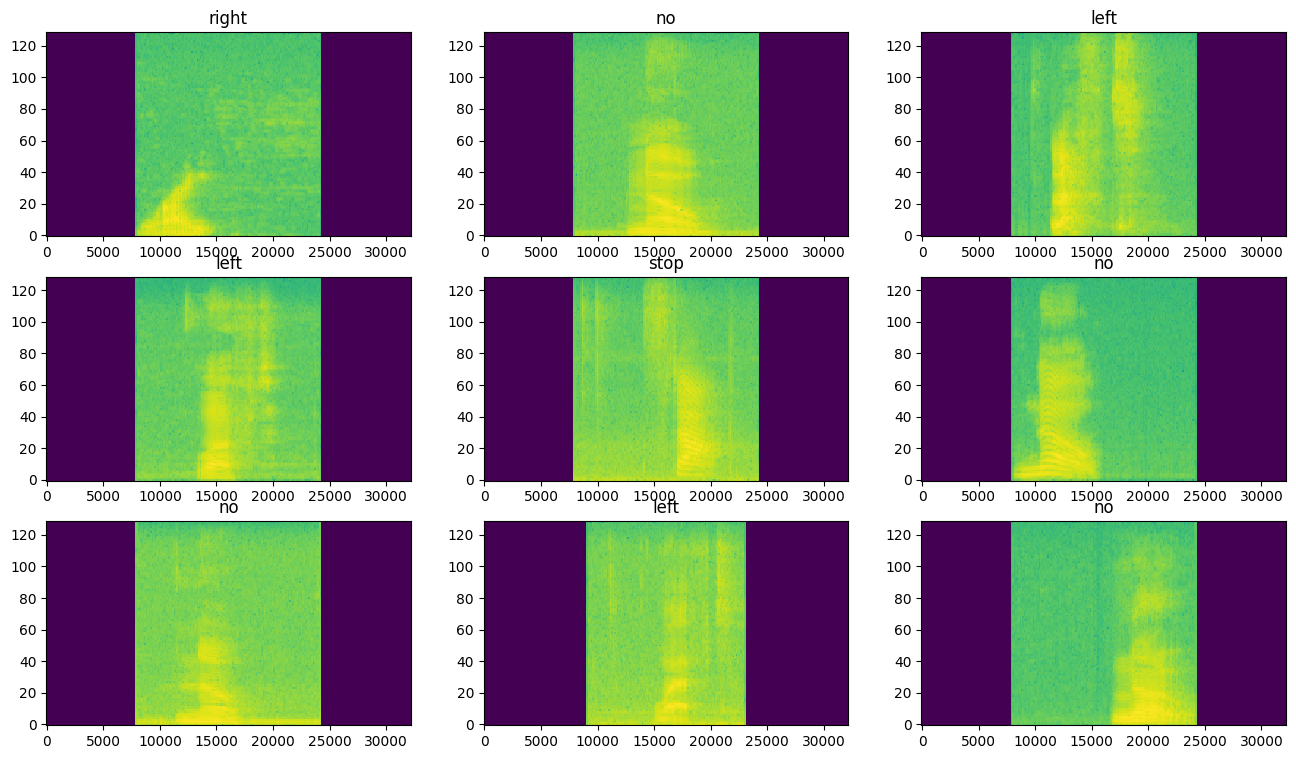

In [22]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## 构建并训练模型

添加 `Dataset.cache` 和 `Dataset.prefetch` 运算以减少训练模型时的读取延迟：

In [23]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

对于模型，您将使用简单的卷积神经网络 (CNN)，因为您已将音频文件转换为频谱图图像。

您的 `tf.keras.Sequential` 模型将使用以下 Keras 预处理层：

- `tf.keras.layers.Resizing`：对输入进行下采样以使模型训练得更快。
- `tf.keras.layers.Normalization`：根据图像的均值和标准差对图像中的每个像素进行归一化。

对于 `Normalization` 层，首先需要在训练数据上调用其 `adapt` 方法，以计算聚合统计数据（即均值和标准差）。

In [25]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
print('Confirm labels:', num_labels, label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (249, 129, 1)
Confirm labels: 8 ['go' 'heymax' 'left' 'no' 'right' 'stop' 'up' 'yes']


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

使用 Adam 优化器和交叉熵损失配置 Keras 模型：

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

出于演示目的，将模型训练超过 10 个周期：

In [40]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8702 - loss: 0.3538 - val_accuracy: 0.8665 - val_loss: 0.5086
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8839 - loss: 0.3251 - val_accuracy: 0.8665 - val_loss: 0.4987
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.8887 - loss: 0.3028 - val_accuracy: 0.8750 - val_loss: 0.4928
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8943 - loss: 0.2862 - val_accuracy: 0.8722 - val_loss: 0.4957
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9045 - loss: 0.2834 - val_accuracy: 0.8778 - val_loss: 0.5302
Epoch 5: early stopping


我们来绘制训练和验证损失曲线，以检查您的模型在训练期间的改进情况：

Text(0, 0.5, 'Accuracy [%]')

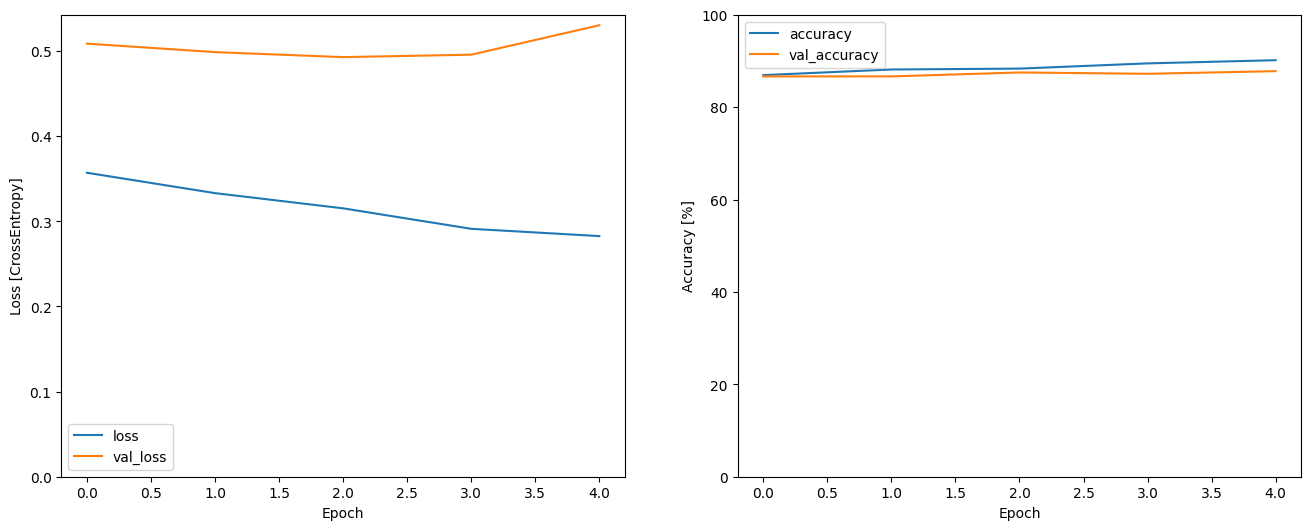

In [41]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## 评估模型性能

在测试集上运行模型并检查模型的性能：

In [29]:
model.evaluate(test_spectrogram_ds, return_dict=True)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.8269 - loss: 0.5191


{'accuracy': 0.834269642829895, 'loss': 0.5225841403007507}

### 显示混淆矩阵

使用<a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">混淆矩阵</a>检查模型对测试集中每个命令的分类效果：


In [30]:
y_pred = model.predict(test_spectrogram_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [31]:
y_pred = tf.argmax(y_pred, axis=1)

In [32]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

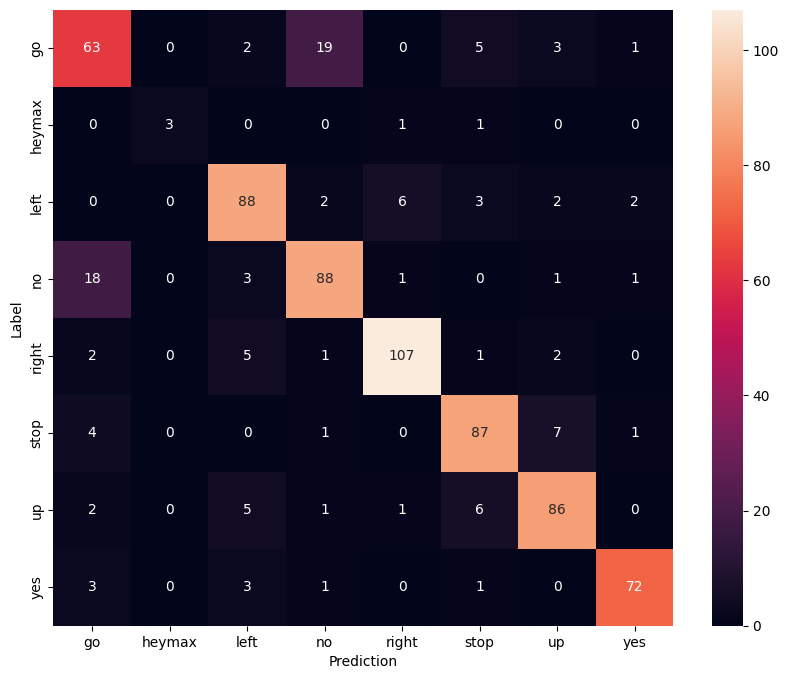

In [33]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## 对音频文件运行推断

最后，使用某人说“no”的输入音频文件验证模型的预测输出。您的模型表现如何？

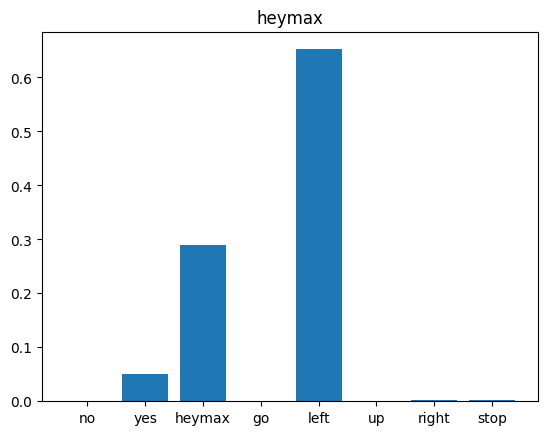

In [42]:
x = 'trigger_example/heymax.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=32000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'heymax', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('heymax')
plt.show()

display.display(display.Audio(waveform, rate=16000))

如输出所示，您的模型应该已将音频命令识别为“no”。

## 通过预处理导出模型

如果您必须在将数据传递给模型进行推断之前应用这些预处理步骤，则该模型不是很易于使用。因此，构建一个端到端的版本：

In [43]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 32000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=32000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

测试运行“导出”模型：

In [46]:
export = ExportModel(model)
export(tf.constant(str('trigger_example/heymax.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[-2.5464168,  1.102229 ,  2.835208 , -4.382398 ,  3.6448755,
         -6.2163806, -2.450027 , -1.6492542]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([4], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'right'], dtype=object)>}

保存并重新加载模型，重新加载的模型给出了相同的输出：

In [45]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[-2.5464168,  1.102229 ,  2.835208 , -4.382398 ,  3.6448755,
         -6.2163806, -2.450027 , -1.6492542]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([4], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'right'], dtype=object)>}

## 后续步骤

本教程演示了如何使用带有 TensorFlow 和 Python 的卷积神经网络执行简单的音频分类/自动语音识别。要了解更多信息，请考虑以下资源：

- [使用 YAMNet 进行声音分类](https://tensorflow.google.cn/hub/tutorials/yamnet)教程展示了如何使用迁移学习进行音频分类。
- 来自 <a href="https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview" class="external">Kaggle 的 TensorFlow 语音识别挑战</a>的笔记本。
- <a href="https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0" class="external">TensorFlow.js - 使用迁移学习的音频识别代码实验室</a>教授如何构建您自己的交互式 Web 应用以进行音频分类。
- arXiv 上的<a href="https://arxiv.org/abs/1709.04396" class="external">音乐信息检索深度学习教程</a>（Choi 等人，2017 年）。
- TensorFlow 还为[音频数据准备和增强](https://tensorflow.google.cn/io/tutorials/audio)提供额外支持，以帮助您完成基于音频的项目。
- 考虑使用 [librosa](https://librosa.org/) 库进行音乐和音频分析。